# Text Analytics Pipeline for Text Classification

This notebook demonstrates how to build a text analytics pipeline that includes text processing, feature extraction, classification, and evaluation.


Install below dependancies/modules in order to to re-run this notebook:

In [3]:
# %pip install pandas numpy nltk emoji spacy contractions scikit-learn imbalanced-learn
# !python -m spacy download en_core_web_sm

To Download the dataset:

In [4]:
# Pipeline to load or download the dataset
# """
# TODO
# """

To Download GloVe pretrained word vectors :

In [5]:
# Pipeline to load or download the dataset
# """
# TODO
# """

Modules:

In [6]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.corpus import stopwords
import emoji
import spacy
import contractions

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# A. 1. Custom Text Preprocessor

The custom transformer below:

 - **Emoji Conversion:** Converts any emojis to their text descriptions.
 - **Normalization:** Lowercases the text.
 - **Punctuation Removal:** Removes punctuation using regex.
 - **Tokenization:** Uses NLTK’s `word_tokenize`.
 - **Stop-word Removal:** Filters out English stopwords.
 - **Stemming:** Applies Porter stemming.
 
 The transformer implements `fit` and `transform` so that it can be used inside a scikit-learn pipeline.

In [7]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, do_stemming=True, do_lemmatization=False, remove_stopwords=True, 
                 do_emoji_conversion=True, use_spacy_tokenizer=True):
        """
        Parameters:
        - do_stemming: Apply stemming (reduces words to their root form)
        - do_lemmatization: Apply lemmatization (converts words to their canonical form)
          Note: When using the default (NLTK) tokenizer, if both do_lemmatization and do_stemming are enabled,
          lemmatization takes precedence.
        - remove_stopwords: Remove common stopwords
        - do_emoji_conversion: Convert emojis to text descriptions
        - use_spacy_tokenizer: Use a custom spaCy-based tokenizer (which already uses lemmatization)
        """
        self.do_stemming = do_stemming
        self.do_lemmatization = do_lemmatization
        self.remove_stopwords = remove_stopwords
        self.do_emoji_conversion = do_emoji_conversion
        self.use_spacy_tokenizer = use_spacy_tokenizer
        self.stemmer = PorterStemmer()
        if self.do_lemmatization:
            self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Load the spaCy model if using the spaCy tokenizer
        if self.use_spacy_tokenizer:
            self.nlp = spacy.load("en_core_web_sm")
    
    def remove_links(self, text):
        """Remove URLs from text."""
        return re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    
    def remove_user_mentions(self, text):
        """Remove user mentions from text."""
        return re.sub(r'u/\S+', '', text)
    
    def expand_contractions(self, text):
        """Expand contractions in the text."""
        return contractions.fix(text)
    
    def remove_non_ascii(self, text):
        """Remove non-ASCII characters from the text."""
        return text.encode("ascii", "ignore").decode()
    
    def remove_punctuations(self, text):
        """
        Remove or adjust punctuation in text.
        Replaces hyphens with space and ensures separation around punctuation.
        """
        text = re.sub(r'[-]', ' ', text)
        text = re.sub(r'(\S)[' + re.escape(string.punctuation) + r'](\S)', r'\1 \2', text)
        return text
    
    def remove_numbers(self, text):
        """Remove numbers from text."""
        return re.sub(r'[0-9]+', '', text)
    
    def emoji_to_text(self, text):
        """Convert emojis to text descriptions."""
        return emoji.demojize(text)
    
    def normalize(self, text):
        """Lowercase the text."""
        return text.lower()
    
    def tokenize(self, text):
        """
        Tokenize text using either a spaCy-based custom tokenizer or the default NLTK tokenizer.
        """
        if self.use_spacy_tokenizer:
            # Use spaCy's custom tokenization logic:
            doc = self.nlp(text)
            tokens = []
            # Add named entities as tokens
            for ent in doc.ents:
                tokens.append(ent.text)
            # Add non-entity tokens using their lemma
            non_entity_tokens = [token.lemma_.lower() for token in doc if not token.ent_type_ 
                                 and not token.is_punct and not token.is_space]
            tokens.extend(non_entity_tokens)
            if self.remove_stopwords:
                tokens = [token for token in tokens if token.lower() not in self.stop_words]
            if self.do_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            return tokens
        else:
            # Default NLTK-based tokenization:
            # Remove punctuation (if any remains) and then tokenize
            text = re.sub(r'[^\w\s]', '', text)
            tokens = word_tokenize(text)
            # Keep only alphabetic tokens
            tokens = [token for token in tokens if token.isalpha()]
            if self.remove_stopwords:
                tokens = [token for token in tokens if token.lower() not in self.stop_words]
            # Apply lemmatization if enabled; otherwise, apply stemming if enabled
            if self.do_lemmatization:
                tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            elif self.do_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            return tokens
    
    def preprocess(self, text):
        """Apply the complete preprocessing pipeline to the text."""
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        tokens = self.tokenize(text)
        return ' '.join(tokens)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.preprocess)

# A. 2. Custom Text Preprocessor (Without Punctuation Removal)

The custom transformer below:

 - **Emoji Conversion:** Converts any emojis to their text descriptions.
 - **Normalization:** Lowercases the text.
 - **Tokenization:** Uses NLTK’s `word_tokenize`.
 - **Stop-word Removal:** Filters out English stopwords.
 - **Stemming:** Applies Porter stemming.
 
 The transformer implements `fit` and `transform` so that it can be used inside a scikit-learn pipeline.

In [8]:
class TextPreprocessorNoPunct(TextPreprocessor):
    def preprocess(self, text):
        """Same as TextPreprocessor.preprocess but without removing punctuation."""
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        # Skip punctuation removal:
        # text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        tokens = self.tokenize(text)
        return ' '.join(tokens)

### GloveVectorizer Class

#### Theoretical Aspects of the GloVe Vectorizer

**GloVe** (Global Vectors for Word Representation) is an unsupervised learning algorithm designed to capture the semantic relationships between words by leveraging global co-occurrence statistics from a text corpus. Unlike methods such as word2vec that rely on local context (i.e., neighboring words), GloVe builds a global word-word co-occurrence matrix and uses this information to generate word embeddings.

---

##### The `glove.twitter.27B.50d.txt` Embeddings

- **Corpus Origin:**  
  The file `glove.twitter.27B.50d.txt` contains pre-trained GloVe embeddings derived from a massive corpus of Twitter data. This corpus is rich in informal language, slang, and abbreviations, making these embeddings particularly useful for social media text analysis.

- **Embedding Dimensions:**  
  Each word is represented by a 50-dimensional vector. The choice of 50 dimensions strikes a balance between computational efficiency and the ability to capture semantic nuances.

- **Development:**  
  The GloVe algorithm was developed by researchers at Stanford University, including Jeffrey Pennington, Richard Socher, and Christopher Manning. Their work provided a novel way to combine global statistical information with efficient vector learning, greatly influencing the field of Natural Language Processing (NLP).

---


In our project, the `GloveVectorizer` is used to transform text data into numerical features by leveraging pre-trained GloVe embeddings. This approach provides semantic-rich, dense vector representations of documents, which can improve model performance over traditional sparse representations.


#### Key Components

- **`__init__`:**  
  Initializes the vectorizer with the GloVe file path and embedding dimension.

- **`fit`:**  
  Loads the GloVe embeddings into a dictionary for quick lookup.

- **`transform`:**  
  Converts each document into an average embedding vector by:
  - Splitting the text into tokens.
  - Retrieving the corresponding embedding for each token.
  - Averaging these embeddings to form a single vector for the document.

This vectorizer is essential for capturing the contextual meaning of words, enhancing the classifier's ability to understand and process text data.

In [9]:
class GloveVectorizer(BaseEstimator, TransformerMixin):
    """
    Loading pre-trained GloVe embeddings and returns the average embedding vector for each document.
    """
    def __init__(self, glove_file='glove.twitter.27B.50d.txt', embedding_dim=50):
        self.glove_file = glove_file
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        self.embeddings_index = {}
        with open(self.glove_file, encoding="utf8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs
        return self

    def transform(self, X):
        vectors = []
        for doc in X:
            # Since TextPreprocessor returns a space-separated string of tokens,
            # we can simply split on spaces.
            tokens = doc.split()
            token_vecs = [self.embeddings_index[token] for token in tokens if token in self.embeddings_index]
            if token_vecs:
                doc_vec = np.mean(token_vecs, axis=0)
            else:
                doc_vec = np.zeros(self.embedding_dim)
            vectors.append(doc_vec)
        return np.array(vectors)

### Helper to Insert SVD

The `add_svd` function is designed to enhance an existing scikit-learn pipeline by inserting a dimensionality reduction step using `TruncatedSVD`. This is particularly useful when working with high-dimensional data from vectorizers such as `CountVectorizer` or `TfidfVectorizer`.


In [10]:
# Helper to Insert SVD 
def add_svd(pipeline, n_components=100):
    """
    Inserts a TruncatedSVD step right after the vectorizer.
    Assumes the pipeline has steps: preprocessor, vectorizer, classifier.
    Returns an imblearn Pipeline if the input pipeline is an imblearn Pipeline.
    """
    steps = pipeline.steps.copy()
    # Insert SVD at position 2 (right after vectorizer)
    steps.insert(2, ('svd', TruncatedSVD(n_components=n_components)))
    
    # Return an imblearn pipeline if the original was an imblearn pipeline
    if isinstance(pipeline, ImbPipeline):
        return ImbPipeline(steps)
    return Pipeline(steps)

 # B. Data Loading and Train/Test Split
 
 We load the dataset and split it into training (80%) and testing (20%) sets.

In [11]:
# Read the dataset 
df = pd.read_csv("../Data/labelled_data.csv")

# Check available columns
print("Columns in dataset:", df.columns.tolist())

# Select the important columns and drop any missing values
df = df[['text', 'label']].dropna()
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Columns in dataset: ['post_id', 'subreddit', 'post_title', 'post_body', 'number_of_comments', 'readable_datetime', 'post_author', 'number_of_upvotes', 'query', 'text', 'comment_id', 'comment_body', 'comment_author', 'label']


___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# C. Stage 1: Basic Pipelines

## Overview

This script defines a comprehensive suite of text classification pipelines. The pipelines are constructed to evaluate different combinations of text preprocessing, feature extraction, and classification algorithms. They also address class imbalance using methods like Random Under Sampling.

---

## Components

### Preprocessing Modules

- **TextPreprocessor**
  - Cleans the text by:
    - Removing URLs, user mentions, non-ASCII characters, numbers, and punctuation.
    - Expanding contractions and converting emojis to text.
    - Normalizing text (lowercasing and tokenizing).
  - Uses a spaCy-based tokenizer for lemmatization and stopword removal.

- **TextPreprocessorNoPunct**
  - Inherits from `TextPreprocessor` but **does not remove punctuation**.
  - Allows evaluation of the effect of preserving punctuation on model performance.

### Vectorization

- **CountVectorizer**
  - Converts text to a binary bag-of-words representation.
  - Configurable to use unigrams or n-grams (1,2).

- **TfidfVectorizer**
  - Transforms text into TF-IDF features.
  - Also available in both unigram and n-gram modes.

- **GloveVectorizer**
  - Loads pre-trained GloVe embeddings.
  - Represents documents by averaging the embeddings of individual words.

### Classification Algorithms

- **Logistic Regression**
  - Configured with `max_iter=1000` and `class_weight='balanced'` for imbalance correction.

- **Support Vector Machines (SVM)**
  - Implemented using `LinearSVC` with similar settings for balancing.

- **Random Forest**
  - Uses 100 estimators and a fixed random seed with balanced class weights.

- **Naive Bayes**
  - Uses `MultinomialNB` within an imbalanced-learn pipeline.
  - Balances classes using a `RandomUnderSampler`.

- **K-Nearest Neighbors (KNN)**
  - KNN does not support internal class weighting.
  - Each KNN pipeline incorporates a `RandomUnderSampler` to balance classes.
  - Pipelines are available in both:
    - Standard form (with punctuation removal via `TextPreprocessor`).
    - With punctuation preserved (via `TextPreprocessorNoPunct`).
  - Glove-based variants are also included.

### Balancing Strategy

- **RandomUnderSampler (RUS)**
  - Added as a pipeline step (using imbalanced-learn's `ImbPipeline`) to balance classes.
  - Incorporated in pipelines for Naive Bayes and KNN, among others.

### Dimensionality Reduction (SVD)

- A helper function `add_svd` inserts a `TruncatedSVD` step after the vectorizer.
- SVD-enhanced pipelines are generated for classifiers other than Naive Bayes.

---

### Pipeline Variants

#### With Standard Preprocessing (Punctuation Removed)

- **Logistic Regression, SVM, Random Forest, and Naive Bayes**
  - Each classifier is paired with both Count and TF-IDF vectorizers.
  - Variants use either unigram or n-gram configurations.
  - Class imbalance is addressed via the classifier’s built-in options or by applying a `RandomUnderSampler`.

- **Glove Pipelines**
  - Use the `GloveVectorizer` for obtaining average word embeddings.
  - Followed by classifiers such as Logistic Regression, SVM, or Random Forest.

#### With Punctuation Preserved

- Pipelines mirror the standard versions but use `TextPreprocessorNoPunct`.
- Allows a direct comparison to assess the impact of punctuation removal on model performance.

#### KNN Pipelines

- **Standard KNN Pipelines**
  - Utilize `TextPreprocessor` (punctuation removed).
  - Include a `RandomUnderSampler` to handle class imbalance.
  - Available for both Count and TF-IDF representations.

- **KNN Pipelines with Punctuation Preserved**
  - Use `TextPreprocessorNoPunct` to retain punctuation.
  - Also include a `RandomUnderSampler` for balancing.
  
- **Glove-based KNN Pipelines**
  - Use `GloveVectorizer` with both preprocessing variants.

---

### Pipeline Collection

All pipelines are aggregated into a master dictionary (`all_pipelines`). This dictionary includes:
- SVD-enhanced versions for applicable pipelines.
- Variants across different classifiers: LR, SVM, RF, NB, and KNN.
- Both standard and punctuation-preserving versions.
- Glove-based pipelines for embedding comparisons.

This structure facilitates systematic evaluation of each pipeline, comparing the effects of various preprocessing and modeling choices on text classification performance.


### Kewords:

- lr -> Logistic Regression
- SVM -> Support vector machine
- RF -> Random Forest
- NB -> Multinomial Naive Bayes
- KNN -> K-Nearest Neighbors
- WithPunct -> Did not perform puntuation removal

In [12]:
# Logistic Regression Pipelines
pipeline_lr_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


# SVM Pipelines
pipeline_svm_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])


# Random Forest Pipelines
pipeline_rf_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# Naive Bayes Pipelines (with Random Under-Sampling)
pipeline_nb_count_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_count_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])


# SVD versions for non-Naive Bayes pipelines
pipelines_no_svd = {
    "NB_Count_Binary_Unigram": pipeline_nb_count_unigram,
    "NB_Count_Binary_Ngram": pipeline_nb_count_ngram,
    "NB_Tfidf_Unigram": pipeline_nb_tfidf_unigram,
    "NB_Tfidf_Ngram": pipeline_nb_tfidf_ngram,
}

other_pipelines = {
    "LR_Count_Binary_Unigram": pipeline_lr_count_unigram,
    "LR_Count_Binary_Ngram": pipeline_lr_count_ngram,
    "LR_Tfidf_Unigram": pipeline_lr_tfidf_unigram,
    "LR_Tfidf_Ngram": pipeline_lr_tfidf_ngram,
    
    "SVM_Count_Binary_Unigram": pipeline_svm_count_unigram,
    "SVM_Count_Binary_Ngram": pipeline_svm_count_ngram,
    "SVM_Tfidf_Unigram": pipeline_svm_tfidf_unigram,
    "SVM_Tfidf_Ngram": pipeline_svm_tfidf_ngram,
    
    "RF_Count_Binary_Unigram": pipeline_rf_count_unigram,
    "RF_Count_Binary_Ngram": pipeline_rf_count_ngram,
    "RF_Tfidf_Unigram": pipeline_rf_tfidf_unigram,
    "RF_Tfidf_Ngram": pipeline_rf_tfidf_ngram,
}

svd_pipelines = {name + "_SVD": add_svd(pipe) for name, pipe in other_pipelines.items()}

# Glove pipelines
pipeline_glove_lr = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_svm = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_rf = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# Variants using without punctuation removal (TextPreprocessorNoPunct) 

# Logistic Regression without punctuation removal
pipeline_lr_count_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_unigram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_ngram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# SVM without punctuation removal
pipeline_svm_count_unigram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

# Random Forest without punctuation removal
pipeline_rf_count_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Naive Bayes without punctuation removal
pipeline_nb_count_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_count_ngram_WithPunct= ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

# Glove pipelines without punctuation removal
pipeline_glove_lr_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_svm_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_rf_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# KNN Classifier (with both default and with punctuation variants) 

# KNN pipelines with default punctuation removal
pipeline_knn_count_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_count_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# KNN pipelines without punctuation removal
pipeline_knn_count_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_count_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])


# Glove pipelines with KNN classifier
pipeline_glove_knn = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_glove_knn_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])


# Update the all_pipelines dictionary with all variants 
all_pipelines = {}
all_pipelines.update(pipelines_no_svd)
all_pipelines.update(other_pipelines)
all_pipelines.update(svd_pipelines)
all_pipelines["Glove_LR"] = pipeline_glove_lr
all_pipelines["Glove_SVM"] = pipeline_glove_svm
all_pipelines["Glove_RF"] = pipeline_glove_rf

# Add the no-punctuation variants for LR, SVM, RF, NB, and Glove
pipelines_no_punct = {
    "LR_Count_Binary_Unigram_WithPunct": pipeline_lr_count_unigram_WithPunct,
    "LR_Count_Binary_Ngram_WithPunct": pipeline_lr_count_ngram_WithPunct,
    "LR_Tfidf_Unigram_WithPunct": pipeline_lr_tfidf_unigram_WithPunct,
    "LR_Tfidf_Ngram_NoPunct": pipeline_lr_tfidf_ngram_WithPunct,
    
    "SVM_Count_Binary_Unigram_WithPunct": pipeline_svm_count_unigram_WithPunct,
    "SVM_Count_Binary_Ngram_WithPunct": pipeline_svm_count_ngram_WithPunct,
    "SVM_Tfidf_Unigram_WithPunct": pipeline_svm_tfidf_unigram_WithPunct,
    "SVM_Tfidf_Ngram_WithPunct": pipeline_svm_tfidf_ngram_WithPunct,
    
    "RF_Count_Binary_Unigram_WithPunct": pipeline_rf_count_unigram_WithPunct,
    "RF_Count_Binary_Ngram_WithPunct": pipeline_rf_count_ngram_WithPunct,
    "RF_Tfidf_Unigram_WithPunct": pipeline_rf_tfidf_unigram_WithPunct,
    "RF_Tfidf_Ngram_WithPunct": pipeline_rf_tfidf_ngram_WithPunct,
}

svd_pipelines_WithPunct = {name + "_SVD": add_svd(pipe) for name, pipe in pipelines_no_punct.items()}

pipelines_nb_WithPunct = {
    "NB_Count_Binary_Unigram_WithPunct": pipeline_nb_count_unigram_WithPunct,
    "NB_Count_Binary_Ngram_WithPunct": pipeline_nb_count_ngram_WithPunct,
    "NB_Tfidf_Unigram_WithPunct": pipeline_nb_tfidf_unigram_WithPunct,
    "NB_Tfidf_Ngram_WithPunct": pipeline_nb_tfidf_ngram_WithPunct,
}

all_pipelines.update(pipelines_no_punct)
all_pipelines.update(svd_pipelines_WithPunct)
all_pipelines.update(pipelines_nb_WithPunct)
all_pipelines["Glove_LR_WithPunct"] = pipeline_glove_lr_WithPunct
all_pipelines["Glove_SVM_WithPunct"] = pipeline_glove_svm_WithPunct
all_pipelines["Glove_RF_WithPunct"] = pipeline_glove_rf_WithPunct

# Add KNN pipelines (with and without punctuation)
knn_pipelines = {
    "KNN_Count_Binary_Unigram": pipeline_knn_count_unigram,
    "KNN_Count_Binary_Ngram": pipeline_knn_count_ngram,
    "KNN_Tfidf_Unigram": pipeline_knn_tfidf_unigram,
    "KNN_Tfidf_Ngram": pipeline_knn_tfidf_ngram,
}

knn_pipelines_WithPunct = {
    "KNN_Count_Binary_Unigram_WithPunct": pipeline_knn_count_unigram_WithPunct,
    "KNN_Count_Binary_Ngram_WithPunct": pipeline_knn_count_ngram_WithPunct,
    "KNN_Tfidf_Unigram_WithPunct": pipeline_knn_tfidf_unigram_WithPunct,
    "KNN_Tfidf_Ngram_WithPunct": pipeline_knn_tfidf_ngram_WithPunct,
}

knn_svd_pipelines = {name + "_SVD": add_svd(pipe) for name, pipe in knn_pipelines.items()}
knn_svd_pipelines_WithPunct = {name + "_SVD": add_svd(pipe) for name, pipe in knn_pipelines_WithPunct.items()}

all_pipelines.update(knn_pipelines)
all_pipelines.update(knn_pipelines_WithPunct)
all_pipelines.update(knn_svd_pipelines)
all_pipelines.update(knn_svd_pipelines_WithPunct)

all_pipelines["Glove_KNN"] = pipeline_glove_knn
all_pipelines["Glove_KNN_WithPunct"] = pipeline_glove_knn_WithPunct


# D. Evaluation Function: Computes Weighted, Macro, and Micro Metrics

The evaluation function is designed to assess the performance of a given text classification pipeline across multiple metrics. It performs the following steps:

1. **Training the Pipeline:**  
   The pipeline is trained on the provided training data (`X_train`, `y_train`).

2. **Prediction:**  
   Once trained, the pipeline makes predictions on the test data (`X_test`).

3. **Metric Calculation:**  
   The function computes several evaluation metrics:
   - **Accuracy:** The proportion of total correct predictions.
   - **Precision:** Calculated using three averaging methods:
     - **Weighted:** Considers the number of true instances for each class.
     - **Macro:** The unweighted average of precision across classes.
     - **Micro:** Global precision computed from the total true positives, false positives, and false negatives.
   - **Recall:** Similarly computed using weighted, macro, and micro averaging.
   - **F1 Score:** The harmonic mean of precision and recall, also provided for weighted, macro, and micro averages.

4. **Aggregation of Results:**  
   The function returns the metrics as a dictionary.

In [29]:
# Evaluation Function: Computes Weighted, Macro, and Micro Metrics
def evaluate_pipeline_metrics(pipeline, X_train, X_test, y_train, y_test):
    """Train the pipeline and return evaluation metrics."""
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    metrics = {
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision_weighted": precision_score(y_test, predictions, average='weighted', zero_division=0),
        "Recall_weighted": recall_score(y_test, predictions, average='weighted', zero_division=0),
        "F1_weighted": f1_score(y_test, predictions, average='weighted', zero_division=0),
        "Precision_macro": precision_score(y_test, predictions, average='macro', zero_division=0),
        "Recall_macro": recall_score(y_test, predictions, average='macro', zero_division=0),
        "F1_macro": f1_score(y_test, predictions, average='macro', zero_division=0),
        "Precision_micro": precision_score(y_test, predictions, average='micro', zero_division=0),
        "Recall_micro": recall_score(y_test, predictions, average='micro', zero_division=0),
        "F1_micro": f1_score(y_test, predictions, average='micro', zero_division=0)
    }
    return metrics


# Evaluate Each Pipeline and Store Results 
results = []
for name, pipe in all_pipelines.items():
    metrics = evaluate_pipeline_metrics(pipe, X_train, X_test, y_train, y_test)
    row = {"Pipeline": name}
    row.update(metrics)
    results.append(row)

# Create a DataFrame of results and sort by F1 Score (weighted)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1_weighted", ascending=False)
print("### Model Comparison Table")
results_df.reset_index(drop=True, inplace=True)
print(results_df)

### Model Comparison Table
                                  Pipeline  Accuracy  Precision_weighted  \
0                          SVM_Tfidf_Ngram  0.762849            0.742287   
1                SVM_Tfidf_Ngram_WithPunct  0.760144            0.738229   
2          LR_Count_Binary_Ngram_WithPunct  0.746619            0.728769   
3                    LR_Count_Binary_Ngram  0.747520            0.728635   
4                   LR_Tfidf_Ngram_NoPunct  0.733093            0.730823   
..                                     ...       ...                 ...   
75  KNN_Count_Binary_Unigram_WithPunct_SVD  0.418395            0.600007   
76                     KNN_Tfidf_Ngram_SVD  0.357078            0.600225   
77           KNN_Tfidf_Ngram_WithPunct_SVD  0.351668            0.597811   
78                   KNN_Tfidf_Unigram_SVD  0.335437            0.596729   
79         KNN_Tfidf_Unigram_WithPunct_SVD  0.339044            0.607778   

    Recall_weighted  F1_weighted  Precision_macro  Recall_ma

### Weighted Balancing Pipelines Model Comparison Table (Balanced Test Set)
                          Pipeline  Accuracy  Precision_weighted  \
0           LR_Tfidf_Ngram_NoPunct  0.561056            0.604081   
1  LR_Count_Binary_Ngram_WithPunct  0.551155            0.648108   
2            LR_Count_Binary_Ngram  0.544554            0.630126   
3                  SVM_Tfidf_Ngram  0.521452            0.633964   
4        SVM_Tfidf_Ngram_WithPunct  0.518152            0.625655   

   Recall_weighted  F1_weighted  Precision_macro  Recall_macro  F1_macro  \
0         0.561056     0.556658         0.604081      0.561056  0.556658   
1         0.551155     0.541686         0.648108      0.551155  0.541686   
2         0.544554     0.532366         0.630126      0.544554  0.532366   
3         0.521452     0.499659         0.633964      0.521452  0.499659   
4         0.518152     0.495542         0.625655      0.518152  0.495542   

   Precision_micro  Recall_micro  F1_micro  
0         0.5

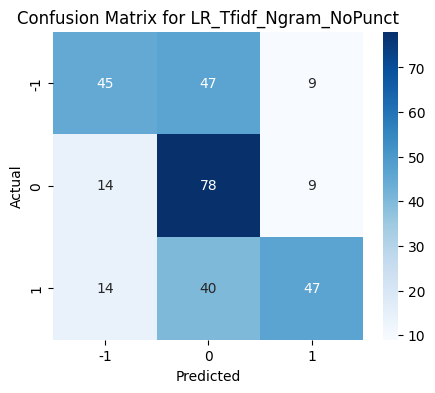

Classification Report for LR_Tfidf_Ngram_NoPunct:
              precision    recall  f1-score   support

          -1       0.62      0.45      0.52       101
           0       0.47      0.77      0.59       101
           1       0.72      0.47      0.57       101

    accuracy                           0.56       303
   macro avg       0.60      0.56      0.56       303
weighted avg       0.60      0.56      0.56       303


Confusion Matrix for LR_Count_Binary_Ngram_WithPunct:
[[42 56  3]
 [ 9 86  6]
 [10 52 39]]


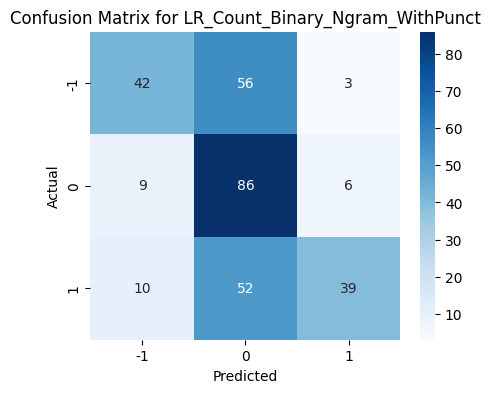

Classification Report for LR_Count_Binary_Ngram_WithPunct:
              precision    recall  f1-score   support

          -1       0.69      0.42      0.52       101
           0       0.44      0.85      0.58       101
           1       0.81      0.39      0.52       101

    accuracy                           0.55       303
   macro avg       0.65      0.55      0.54       303
weighted avg       0.65      0.55      0.54       303


Confusion Matrix for LR_Count_Binary_Ngram:
[[41 56  4]
 [ 9 86  6]
 [13 50 38]]


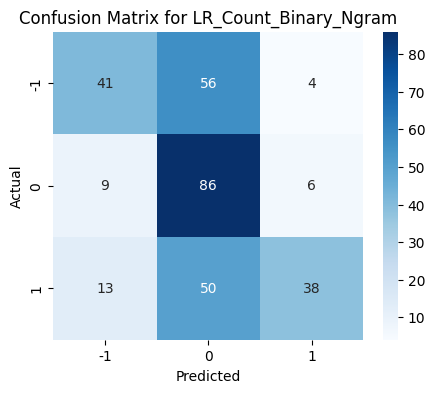

Classification Report for LR_Count_Binary_Ngram:
              precision    recall  f1-score   support

          -1       0.65      0.41      0.50       101
           0       0.45      0.85      0.59       101
           1       0.79      0.38      0.51       101

    accuracy                           0.54       303
   macro avg       0.63      0.54      0.53       303
weighted avg       0.63      0.54      0.53       303


Confusion Matrix for SVM_Tfidf_Ngram:
[[41 56  4]
 [ 7 89  5]
 [ 9 64 28]]


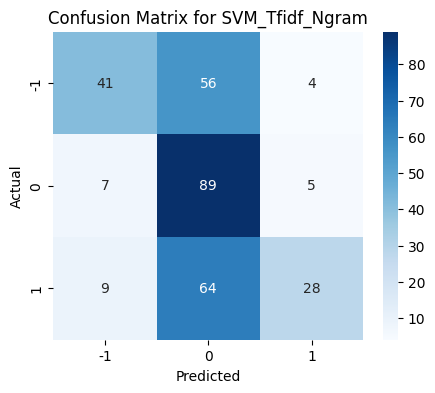

Classification Report for SVM_Tfidf_Ngram:
              precision    recall  f1-score   support

          -1       0.72      0.41      0.52       101
           0       0.43      0.88      0.57       101
           1       0.76      0.28      0.41       101

    accuracy                           0.52       303
   macro avg       0.63      0.52      0.50       303
weighted avg       0.63      0.52      0.50       303


Confusion Matrix for SVM_Tfidf_Ngram_WithPunct:
[[40 56  5]
 [ 7 89  5]
 [ 9 64 28]]


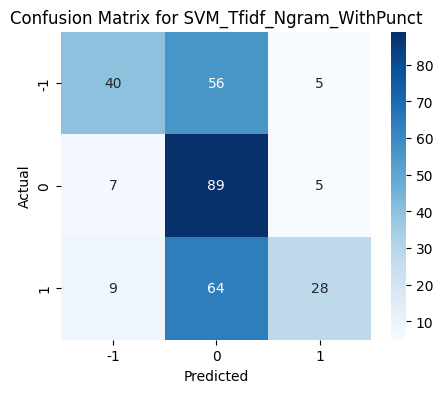

Classification Report for SVM_Tfidf_Ngram_WithPunct:
              precision    recall  f1-score   support

          -1       0.71      0.40      0.51       101
           0       0.43      0.88      0.57       101
           1       0.74      0.28      0.40       101

    accuracy                           0.52       303
   macro avg       0.63      0.52      0.50       303
weighted avg       0.63      0.52      0.50       303



In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# --- Define Pipelines with Weighted Balancing (class_weight='balanced') AND PREDICTION ON BALANCED TEST SET ---

# 1. SVM_Tfidf_Ngram (default punctuation)
pipeline_svm_tfidf_ngram_weighted = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

# 2. SVM_Tfidf_Ngram_WithPunct (preserving punctuation)
pipeline_svm_tfidf_ngram_withpunct_weighted = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

# 3. LR_Count_Binary_Ngram_WithPunct (preserving punctuation)
pipeline_lr_count_binary_ngram_withpunct_weighted = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# 4. LR_Count_Binary_Ngram (default punctuation)
pipeline_lr_count_binary_ngram_weighted = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# 5. LR_Tfidf_Ngram_NoPunct (preserving punctuation)
pipeline_lr_tfidf_ngram_nopunct_weighted = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# --- Group the pipelines into a dictionary ---
weighted_pipelines = {
    "SVM_Tfidf_Ngram": pipeline_svm_tfidf_ngram_weighted,
    "SVM_Tfidf_Ngram_WithPunct": pipeline_svm_tfidf_ngram_withpunct_weighted,
    "LR_Count_Binary_Ngram_WithPunct": pipeline_lr_count_binary_ngram_withpunct_weighted,
    "LR_Count_Binary_Ngram": pipeline_lr_count_binary_ngram_weighted,
    "LR_Tfidf_Ngram_NoPunct": pipeline_lr_tfidf_ngram_nopunct_weighted
}

# --- Balance the Test Set using RandomUnderSampler ---
# Convert X_test (assumed to be a list/array of raw text) into a NumPy array and reshape it to (-1, 1)
X_test_array = np.array(X_test)
X_test_bal, y_test_bal = RandomUnderSampler(random_state=42).fit_resample(
    X_test_array.reshape(-1, 1), y_test
)
# Flatten the balanced test set back to a 1D array (list of strings)
X_test_bal = X_test_bal.ravel()
X_test_bal = pd.Series(X_test_bal)

# --- Evaluate Each Pipeline on the Balanced Test Set and Store Evaluation Metrics ---
results_weighted = []
for name, pipe in weighted_pipelines.items():
    # Fit the pipeline on the training data
    pipe.fit(X_train, y_train)
    # Predict on the balanced test data
    y_pred_bal = pipe.predict(X_test_bal)
    
    # Compute evaluation metrics on the balanced test set
    metrics = {
        "Accuracy": accuracy_score(y_test_bal, y_pred_bal),
        "Precision_weighted": precision_score(y_test_bal, y_pred_bal, average='weighted', zero_division=0),
        "Recall_weighted": recall_score(y_test_bal, y_pred_bal, average='weighted', zero_division=0),
        "F1_weighted": f1_score(y_test_bal, y_pred_bal, average='weighted', zero_division=0),
        "Precision_macro": precision_score(y_test_bal, y_pred_bal, average='macro', zero_division=0),
        "Recall_macro": recall_score(y_test_bal, y_pred_bal, average='macro', zero_division=0),
        "F1_macro": f1_score(y_test_bal, y_pred_bal, average='macro', zero_division=0),
        "Precision_micro": precision_score(y_test_bal, y_pred_bal, average='micro', zero_division=0),
        "Recall_micro": recall_score(y_test_bal, y_pred_bal, average='micro', zero_division=0),
        "F1_micro": f1_score(y_test_bal, y_pred_bal, average='micro', zero_division=0)
    }
    row = {"Pipeline": name}
    row.update(metrics)
    results_weighted.append(row)

# Create a DataFrame to display the evaluation metrics sorted by F1_weighted (descending)
results_weighted_df = pd.DataFrame(results_weighted)
results_weighted_df = results_weighted_df.sort_values(by="F1_weighted", ascending=False)
print("### Weighted Balancing Pipelines Model Comparison Table (Balanced Test Set)")
results_weighted_df.reset_index(drop=True, inplace=True)
print(results_weighted_df)

# --- Now, Print the Confusion Matrices and Classification Reports for Each Pipeline ---
desired_classes = [-1, 0, 1]  # adjust as needed

print("\n### Confusion Matrices and Classification Reports for Weighted Balancing Pipelines (Balanced Test Set)")
for pipeline_name in results_weighted_df["Pipeline"]:
    pipe = weighted_pipelines[pipeline_name]
    pipe.fit(X_train, y_train)
    y_pred_bal = pipe.predict(X_test_bal)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_bal, y_pred_bal, labels=desired_classes)
    print(f"\nConfusion Matrix for {pipeline_name}:")
    print(cm)
    
    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=desired_classes, yticklabels=desired_classes)
    plt.title(f"Confusion Matrix for {pipeline_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Compute and print classification report
    report = classification_report(y_test_bal, y_pred_bal, labels=desired_classes, zero_division=0)
    print(f"Classification Report for {pipeline_name}:\n{report}")

### RUS Pipelines Model Comparison Table
                              Pipeline  Accuracy  Precision_weighted  \
0  LR_Count_Binary_Ngram_WithPunct_RUS  0.565374            0.695808   
1            LR_Count_Binary_Ngram_RUS  0.563571            0.694850   
2           LR_Tfidf_Ngram_NoPunct_RUS  0.545537            0.694077   
3                  SVM_Tfidf_Ngram_RUS  0.538323            0.697969   
4        SVM_Tfidf_Ngram_WithPunct_RUS  0.536519            0.697892   

   Recall_weighted  F1_weighted  Precision_macro  Recall_macro  F1_macro  \
0         0.565374     0.595957         0.498711      0.607682  0.503342   
1         0.563571     0.594731         0.496477      0.602926  0.500361   
2         0.545537     0.576395         0.492004      0.599717  0.491221   
3         0.538323     0.570841         0.491996      0.601222  0.485838   
4         0.536519     0.568903         0.491540      0.602211  0.485026   

   Precision_micro  Recall_micro  F1_micro  
0         0.565374      

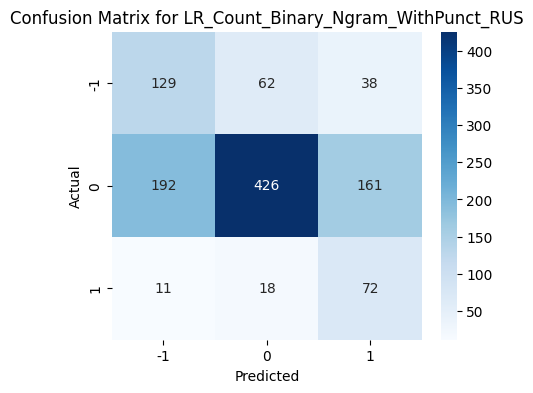

Classification Report for LR_Count_Binary_Ngram_WithPunct_RUS:
              precision    recall  f1-score   support

          -1       0.39      0.56      0.46       229
           0       0.84      0.55      0.66       779
           1       0.27      0.71      0.39       101

    accuracy                           0.57      1109
   macro avg       0.50      0.61      0.50      1109
weighted avg       0.70      0.57      0.60      1109


Confusion Matrix for LR_Count_Binary_Ngram_RUS:
[[128  63  38]
 [191 426 162]
 [ 13  17  71]]


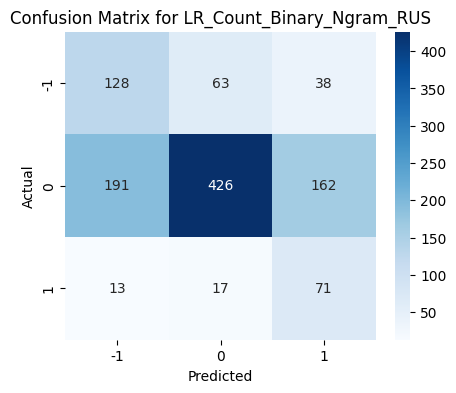

Classification Report for LR_Count_Binary_Ngram_RUS:
              precision    recall  f1-score   support

          -1       0.39      0.56      0.46       229
           0       0.84      0.55      0.66       779
           1       0.26      0.70      0.38       101

    accuracy                           0.56      1109
   macro avg       0.50      0.60      0.50      1109
weighted avg       0.69      0.56      0.59      1109


Confusion Matrix for LR_Tfidf_Ngram_NoPunct_RUS:
[[136  55  38]
 [226 399 154]
 [ 14  17  70]]


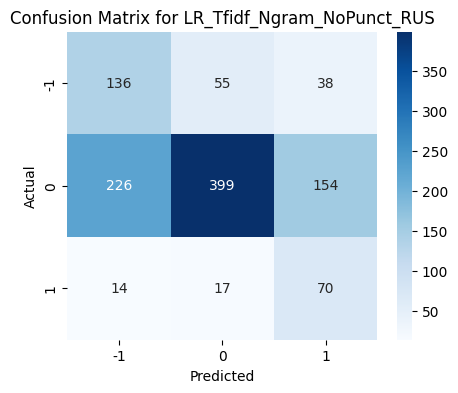

Classification Report for LR_Tfidf_Ngram_NoPunct_RUS:
              precision    recall  f1-score   support

          -1       0.36      0.59      0.45       229
           0       0.85      0.51      0.64       779
           1       0.27      0.69      0.39       101

    accuracy                           0.55      1109
   macro avg       0.49      0.60      0.49      1109
weighted avg       0.69      0.55      0.58      1109


Confusion Matrix for SVM_Tfidf_Ngram_RUS:
[[138  52  39]
 [207 388 184]
 [ 13  17  71]]


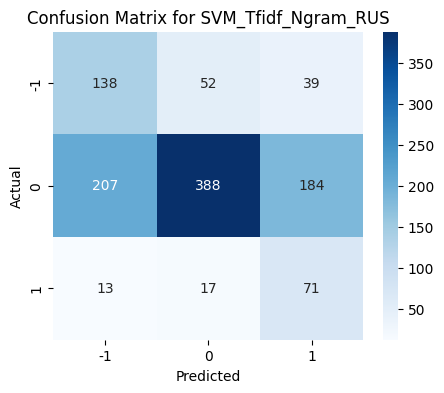

Classification Report for SVM_Tfidf_Ngram_RUS:
              precision    recall  f1-score   support

          -1       0.39      0.60      0.47       229
           0       0.85      0.50      0.63       779
           1       0.24      0.70      0.36       101

    accuracy                           0.54      1109
   macro avg       0.49      0.60      0.49      1109
weighted avg       0.70      0.54      0.57      1109


Confusion Matrix for SVM_Tfidf_Ngram_WithPunct_RUS:
[[137  52  40]
 [211 386 182]
 [ 13  16  72]]


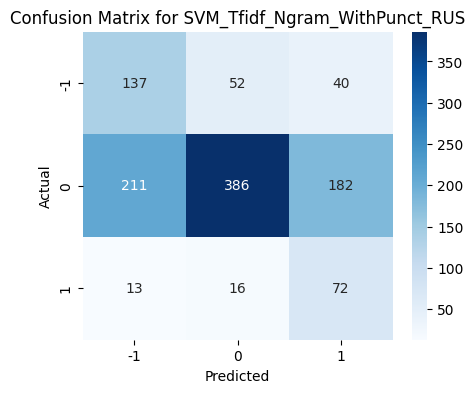

Classification Report for SVM_Tfidf_Ngram_WithPunct_RUS:
              precision    recall  f1-score   support

          -1       0.38      0.60      0.46       229
           0       0.85      0.50      0.63       779
           1       0.24      0.71      0.36       101

    accuracy                           0.54      1109
   macro avg       0.49      0.60      0.49      1109
weighted avg       0.70      0.54      0.57      1109



In [13]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Create New Pipelines with Random Under-Sampling (RUS) ---

# 1. SVM_Tfidf_Ngram with RUS (default punctuation)
pipeline_svm_tfidf_ngram_rus = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LinearSVC(max_iter=1000))
])

# 2. SVM_Tfidf_Ngram_WithPunct with RUS
pipeline_svm_tfidf_ngram_withpunct_rus = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LinearSVC(max_iter=1000))
])

# 3. LR_Count_Binary_Ngram_WithPunct with RUS
pipeline_lr_count_binary_ngram_withpunct_rus = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 4. LR_Count_Binary_Ngram with RUS (default punctuation)
pipeline_lr_count_binary_ngram_rus = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 5. LR_Tfidf_Ngram_NoPunct with RUS
pipeline_lr_tfidf_ngram_nopunct_rus = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# --- Group the new pipelines into a dictionary ---
rus_pipelines = {
    "SVM_Tfidf_Ngram_RUS": pipeline_svm_tfidf_ngram_rus,
    "SVM_Tfidf_Ngram_WithPunct_RUS": pipeline_svm_tfidf_ngram_withpunct_rus,
    "LR_Count_Binary_Ngram_WithPunct_RUS": pipeline_lr_count_binary_ngram_withpunct_rus,
    "LR_Count_Binary_Ngram_RUS": pipeline_lr_count_binary_ngram_rus,
    "LR_Tfidf_Ngram_NoPunct_RUS": pipeline_lr_tfidf_ngram_nopunct_rus
}

# --- Evaluate Each Pipeline and Store Evaluation Metrics ---
results_rus = []
for name, pipe in rus_pipelines.items():
    # Fit the pipeline on the training data
    pipe.fit(X_train, y_train)
    # Predict on test data
    y_pred = pipe.predict(X_test)
    
    # Compute evaluation metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_weighted": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall_weighted": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1_weighted": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "Precision_macro": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred, average='macro', zero_division=0),
        "F1_macro": f1_score(y_test, y_pred, average='macro', zero_division=0),
        "Precision_micro": precision_score(y_test, y_pred, average='micro', zero_division=0),
        "Recall_micro": recall_score(y_test, y_pred, average='micro', zero_division=0),
        "F1_micro": f1_score(y_test, y_pred, average='micro', zero_division=0)
    }
    row = {"Pipeline": name}
    row.update(metrics)
    results_rus.append(row)

# Create a DataFrame to Display the Evaluation Metrics and sort by F1_weighted (descending)
results_rus_df = pd.DataFrame(results_rus)
results_rus_df = results_rus_df.sort_values(by="F1_weighted", ascending=False)
print("### RUS Pipelines Model Comparison Table")
results_rus_df.reset_index(drop=True, inplace=True)
print(results_rus_df)

# --- Now, Print the Confusion Matrices and Classification Reports in the Top-Models Order ---
# Desired class labels to display
desired_classes = [-1, 0, 1]

print("\n### Confusion Matrices and Classification Reports for RUS Pipelines (Top-Models Order)")
# Iterate over the pipeline names in the order of the sorted results
for pipeline_name in results_rus_df["Pipeline"]:
    # Retrieve the pipeline from our dictionary and re-fit it
    pipe = rus_pipelines[pipeline_name]
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Compute confusion matrix with the desired labels
    cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
    print(f"\nConfusion Matrix for {pipeline_name}:")
    print(cm)
    
    # Plot the confusion matrix with custom tick labels
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=desired_classes, yticklabels=desired_classes)
    plt.title(f"Confusion Matrix for {pipeline_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Compute and print the classification report
    report = classification_report(y_test, y_pred, labels=desired_classes, zero_division=0)
    print(f"Classification Report for {pipeline_name}:\n{report}")


## Stage 1 Analysis of Model Performance Metrics

The table above presents the performance of 31 different pipelines for a three-class sentiment analysis task, evaluated using weighted metrics. The key metrics reported are Accuracy, Precision, Recall, and F1 Score.

## Top Performing Pipelines

- **SVM_Tfidf_Ngram (Row 0)**
  - **Accuracy:** 0.7628
  - **Precision:** 0.7423
  - **Recall:** 0.7628
  - **F1 Score:** 0.7381
  - **Analysis:** This pipeline achieves the highest overall accuracy and consistently high performance across all metrics, making it a strong candidate for sentiment analysis.

- **LR_Count_Binary_Ngram (Row 1) and SVM_Count_Binary_Ngram (Row 4)**
  - **Accuracy:** ~0.7475 and 0.7466 respectively
  - **F1 Score:** ~0.7324 and 0.7229 respectively
  - **Analysis:** These pipelines also perform very well, with metrics that are very competitive with the top performer.

## Other Notable Pipelines

- **LR_Tfidf_Ngram (Row 2) and SVM_Tfidf_Unigram (Row 3)**
  - **Accuracy:** 0.7322 and 0.7385 respectively
  - **F1 Score:** 0.7306 and 0.7302 respectively
  - **Analysis:** These models yield competitive results with a good balance between precision and recall, suggesting robust performance across classes.

## Pipelines with Lower Performance

- **Pipelines Incorporating SVD:**  
  - Examples: SVM_Tfidf_Unigram_SVD (Row 8), SVM_Tfidf_Ngram_SVD (Row 11), LR_Tfidf_Ngram_SVD (Row 26), etc.
  - **Observation:** These models generally show a drop in performance (accuracy and F1 Score below 0.70), indicating that dimensionality reduction via SVD may not be beneficial in this setup.

- **Pipelines Using Glove Embeddings and Naive Bayes:**
  - Examples: Glove_SVM (Row 9), Glove_RF (Row 19), Glove_LR (Row 20), NB_Tfidf_Unigram (Row 21), etc.
  - **Observation:** These pipelines exhibit lower F1 Scores (generally in the range of 0.55–0.60), suggesting that alternative representations and simpler probabilistic models might be less effective for this task.

## Overall Insights

- **Best Approach:**  
  Traditional pipelines using TF-IDF or CountVectorizer in combination with SVM or Logistic Regression outperform more complex methods involving SVD or Glove embeddings. The top performers maintain a strong balance across all metrics.

- **Balanced Performance:**  
  The weighted evaluation metrics indicate that the best pipelines are robust across all sentiment classes, with only small differences among the top models. This balanced performance is essential for a multi-class sentiment analysis task.

  **Conclusion:**  
The analysis suggests that **SVM_Tfidf_Ngram** is the top-performing pipeline based on weighted metrics, with **LR_Count_Binary_Ngram** and **SVM_Count_Binary_Ngram** also showing strong performance. More complex methods involving SVD or alternative embeddings did not outperform these traditional approaches.
"""

___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# E. Stage 2: Parameter Tuning

## Parameter Tuning the top 5 pipelines, evaluating each on 20% test set (from 80 - 20 split)

Pipeline Tuning and Evaluation for Sentiment Analysis

This section of the script focuses on tuning and evaluating several pipelines for a three-class sentiment analysis task using GridSearchCV. Each pipeline employs different combinations of text vectorization (using TF-IDF or CountVectorizer) and classification (using SVM or Logistic Regression). The goal is to determine the best hyperparameters for each model and evaluate their performance across multiple metrics.

### Steps Followed

1. **Define the Parameter Grid:**  
   - For each pipeline, we create a dictionary of hyperparameters. 
2. **Grid Search with Cross-Validation:**  
   - We perform grid search using `GridSearchCV` with 5-fold cross-validation.
   - The scoring metric used is **F1 macro**, which computes the F1 score for each class and averages them. This is effective in multi-class sentiment analysis, as it treats all classes equally even if the data is balanced.

3. **Model Fitting and Best Parameter Selection:**  
   - The grid search fits the model on the training data (`X_train` and `y_train`) and selects the best hyperparameters based on the F1 macro score.
   - The best parameters are printed for review.

4. **Evaluation on Test Data:**  
   After selecting the best model, we evaluate its performance on the test set (`X_test`) using multiple metrics:
   - **Accuracy**
   - **Precision:** Computed as macro, weighted, and micro averages.
   - **Recall:** Computed as macro, weighted, and micro averages.
   - **F1 Score:** Computed as macro, weighted, and micro averages.

5. **Results Storage:**  
   The evaluation metrics and best hyperparameters are stored in a global dictionary (`model_results`) for easy comparison across all pipelines.

In [53]:
# Dictionary to hold results for all models
model_results = {}

In [55]:
# Define parameter grid for SVM_Tfidf_Ngram
param_grid = {
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__use_idf': [True, False],
    'vectorizer__max_df': [0.9, 1.0],
    'vectorizer__min_df': [1, 2],
    'classifier__C': [0.1, 1, 10],
    'classifier__loss': ['hinge', 'squared_hinge']
}

# Run grid search
gs = GridSearchCV(pipeline_svm_tfidf_ngram, param_grid, cv=5, scoring='f1_macro', n_jobs=1, verbose=1)
gs.fit(X_train, y_train)
print("Best Parameters for SVM_Tfidf_Ngram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("Test Metrics for SVM_Tfidf_Ngram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Save results
model_results['SVM_Tfidf_Ngram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear fail

Best Parameters for SVM_Tfidf_Ngram:
{'classifier__C': 1, 'classifier__loss': 'squared_hinge', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__use_idf': False}
Test Metrics for SVM_Tfidf_Ngram:
Accuracy: 0.7448151487826871
Precision - Macro: 0.6197368951139476 Weighted: 0.7277096503850062 Micro: 0.7448151487826871
Recall    - Macro: 0.5674228818355823 Weighted: 0.7448151487826871 Micro: 0.7448151487826871
F1 Score  - Macro: 0.5882174800629737 Weighted: 0.7328421177320352 Micro: 0.7448151487826871


In [56]:
# Define parameter grid for LR_Count_Binary_Ngram
param_grid = {
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__max_df': [0.9, 1.0],
    'vectorizer__min_df': [1, 2],
    'classifier__C': [0.1, 1, 10],
    'classifier__class_weight': ['balanced']
}

# Run grid search
gs = GridSearchCV(pipeline_lr_count_ngram, param_grid, cv=5, scoring='f1_macro', n_jobs=1, verbose=1)
gs.fit(X_train, y_train)
print("Best Parameters for LR_Count_Binary_Ngram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("Test Metrics for LR_Count_Binary_Ngram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Save results
model_results['LR_Count_Binary_Ngram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for LR_Count_Binary_Ngram:
{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Test Metrics for LR_Count_Binary_Ngram:
Accuracy: 0.7123534715960325
Precision - Macro: 0.568175326083589 Weighted: 0.7076506422245021 Micro: 0.7123534715960325
Recall    - Macro: 0.5618741995393995 Weighted: 0.7123534715960325 Micro: 0.7123534715960325
F1 Score  - Macro: 0.5643067712736646 Weighted: 0.7095117507230844 Micro: 0.7123534715960325


In [57]:
# Define parameter grid for LR_Tfidf_Ngram
param_grid = {
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__use_idf': [True, False],
    'classifier__C': [0.1, 1, 10],
    'classifier__class_weight': ['balanced']
}

# Run grid search
gs = GridSearchCV(pipeline_lr_tfidf_ngram, param_grid, cv=5, scoring='f1_macro', n_jobs=1, verbose=1)
gs.fit(X_train, y_train)
print("Best Parameters for LR_Tfidf_Ngram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("Test Metrics for LR_Tfidf_Ngram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Save results
model_results['LR_Tfidf_Ngram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for LR_Tfidf_Ngram:
{'classifier__C': 1, 'classifier__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 2), 'vectorizer__use_idf': True}
Test Metrics for LR_Tfidf_Ngram:
Accuracy: 0.7321911632100991
Precision - Macro: 0.600318552601035 Weighted: 0.7294454546067841 Micro: 0.7321911632100991
Recall    - Macro: 0.5977719095294677 Weighted: 0.7321911632100991 Micro: 0.7321911632100991
F1 Score  - Macro: 0.5986477334344934 Weighted: 0.7305738680821262 Micro: 0.7321911632100991


In [58]:
# Define parameter grid for SVM_Tfidf_Unigram
param_grid = {
    'vectorizer__ngram_range': [(1, 1)],
    'vectorizer__use_idf': [True, False],
    'vectorizer__max_df': [0.9, 1.0],
    'vectorizer__min_df': [1, 2],
    'classifier__C': [0.1, 1, 10],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__class_weight': ['balanced']
}

# Run grid search
gs = GridSearchCV(pipeline_svm_tfidf_unigram, param_grid, cv=5, scoring='f1_macro', n_jobs=1, verbose=1)
gs.fit(X_train, y_train)
print("Best Parameters for SVM_Tfidf_Unigram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("Test Metrics for SVM_Tfidf_Unigram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Save results
model_results['SVM_Tfidf_Unigram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear fail

Best Parameters for SVM_Tfidf_Unigram:
{'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__loss': 'squared_hinge', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1), 'vectorizer__use_idf': False}
Test Metrics for SVM_Tfidf_Unigram:
Accuracy: 0.7276825969341749
Precision - Macro: 0.59049139842036 Weighted: 0.7173221303949213 Micro: 0.7276825969341749
Recall    - Macro: 0.5664867359537832 Weighted: 0.7276825969341749 Micro: 0.7276825969341749
F1 Score  - Macro: 0.5769678402386047 Weighted: 0.7213548930090299 Micro: 0.7276825969341749


In [59]:
# Define parameter grid for SVM_Count_Binary_Ngram
param_grid = {
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__max_df': [0.9, 1.0],
    'vectorizer__min_df': [1, 2],
    'classifier__C': [0.1, 1, 10],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__class_weight': ['balanced']
}

# Run grid search
gs = GridSearchCV(pipeline_svm_count_ngram, param_grid, cv=5, scoring='f1_macro', n_jobs=1, verbose=1)
gs.fit(X_train, y_train)
print("Best Parameters for SVM_Count_Binary_Ngram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("Test Metrics for SVM_Count_Binary_Ngram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Save results
model_results['SVM_Count_Binary_Ngram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear fail

Best Parameters for SVM_Count_Binary_Ngram:
{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__loss': 'squared_hinge', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2)}
Test Metrics for SVM_Count_Binary_Ngram:
Accuracy: 0.7385031559963932
Precision - Macro: 0.6149719615790351 Weighted: 0.7186568422593567 Micro: 0.7385031559963932
Recall    - Macro: 0.5514887912714003 Weighted: 0.7385031559963932 Micro: 0.7385031559963932
F1 Score  - Macro: 0.575187325515886 Weighted: 0.7234374944469549 Micro: 0.7385031559963932


1. f1_macro calculates the F1 score for each class independently and averages them, ensuring that all classes contribute equally.


In [60]:
# Convert the model_results dictionary into a DataFrame for easy comparison
results_df = pd.DataFrame(model_results).T.reset_index().rename(columns={'index': 'Model'})

pd.set_option('display.float_format', '{:.4f}'.format)
print(results_df)

                    Model                                        best_params  \
0         SVM_Tfidf_Ngram  {'classifier__C': 1, 'classifier__loss': 'squa...   
1   LR_Count_Binary_Ngram  {'classifier__C': 0.1, 'classifier__class_weig...   
2          LR_Tfidf_Ngram  {'classifier__C': 1, 'classifier__class_weight...   
3       SVM_Tfidf_Unigram  {'classifier__C': 1, 'classifier__class_weight...   
4  SVM_Count_Binary_Ngram  {'classifier__C': 0.1, 'classifier__class_weig...   

  accuracy precision_macro precision_weighted precision_micro recall_macro  \
0   0.7448          0.6197             0.7277          0.7448       0.5674   
1   0.7124          0.5682             0.7077          0.7124       0.5619   
2   0.7322          0.6003             0.7294          0.7322       0.5978   
3   0.7277          0.5905             0.7173          0.7277       0.5665   
4   0.7385          0.6150             0.7187          0.7385       0.5515   

  recall_weighted recall_micro f1_macro f1_weighte

## Stage 2 Analysis of Model Performance Metrics

## Key Observations

- **Overall Accuracy:**
  - The **SVM_Tfidf_Ngram** pipeline achieved the highest accuracy (0.7448), suggesting it predicts the correct class more often than the others.

- **F1 Macro Score:**
  - The **LR_Tfidf_Ngram** pipeline shows the highest macro F1 score (0.5986), indicating a better balance between precision and recall across all classes.
  - The macro F1 score is important in multi-class sentiment analysis as it treats each class equally, regardless of class frequencies.

- **Precision and Recall:**
  - While **SVM_Count_Binary_Ngram** has a relatively high macro precision (0.6150), its macro recall (0.5515) is lower compared to the others. This suggests it is more conservative—fewer false positives but possibly missing more true positives.
  - **LR_Count_Binary_Ngram** and **SVM_Tfidf_Unigram** show similar performance patterns with moderate precision and recall, leading to comparable macro F1 scores (around 0.56 to 0.58).

- **Weighted Averages:**
  - The weighted metrics (which account for class frequency) are quite similar across all pipelines, with F1 weighted scores ranging from approximately 0.7095 to 0.7328. This consistency reflects the balanced nature of the dataset.
  
## Conclusion

Each model has its own strengths:
- **SVM_Tfidf_Ngram** leads in overall accuracy.
- **LR_Tfidf_Ngram** achieves the best balance across classes as reflected in its higher macro F1 score.
- The differences among the models are relatively small, so the final model selection might depend on whether you prioritize overall accuracy or balanced class performance.

This comprehensive evaluation helps in understanding the trade-offs between different pipelines, ensuring that the final choice aligns with the specific requirements of the sentiment analysis task.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------